<a href="https://colab.research.google.com/github/Vladimirsp81/DLS_2/blob/master/Copy_of_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### **Домашнее задание**
В этом задании вам предстоит обучить свой собственный классификатор биологического гендера человека по аудиозаписи (спектрограмме). На [семинаре](https://vk.cc/atRKR8) 9 мая мы разобрали, как построить спектрограмму и подать ее в нейросеть, а также написали бейзлайн решение на Keras. 

### Задание 1 (20% баллов)
Взяв данные с семинара из датасета TIMIT (библиотека для работы с ним и подготовки данных также есть в семинаре) натренировать сетку так, чтобы на тестовой выборке accuracy_score был больше 0.97. Возможные исследования: conv1d vs conv2d, batch norm, предобученные сетки из `Imagenet`. Обязательно напишите, что вы использовали и какой вывод. Писать можно на любом фреймворке. 
### Задание 2 (30% баллов)
Подумайте, как бы можно было "испортить" данные для тестовой выборки и впоследствии попробовать восстановить скор при помощи аугментаций трейнсета и усложнения архитектуры? Используя данные из `TEST` усложните выборку и посмотрите, как упадет accuracy_score. Следите, чтобы он не падал ниже 70 -- есть риск тогда не обучиться совсем. Вдохновиться аудио аугментациями можно например [здесь](https://vk.cc/atRLgR). Почитать про то, как еще аугментируют данные, но уже на уровне спектрограмм можно [в блоге Google AI](https://vk.cc/9jCCnk). Посмотрите, какие аугментации влияют сильнее всего? На этом этапе мы пока ничего не учим, а только пытаемся испортить скор бейзлайна с семинара.
### Задание 3 (40% баллов)
При помощи изложенных в предыдущем пункте средств, а также идей и хинтов с семинара, постарайтесь улучшить скор модели на "испорченных" данных. Можно делать все, кроме обучения на тесте :). 
### Задание 4 (10% баллов)
Напишите вывод -- если попробовали какие-то архитектуры, аугментации, но это не помогло, тоже обязательно напишите. Расскажите, что пробовали, и что оказалось самым боевым. Здесь будет релевантно сделать таблицу.

Дополнительные материалы и ссылки:
1. [Текстом про то, как делается преобразование в мел-спектрограмму](https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9)
2. [Соревнование по классификации голосовых команд](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)
3. [Данные для распознавания речи на русском языке](https://github.com/snakers4/open_stt)
4. [Проект по генерации музыки](https://openai.com/blog/jukebox/)
5. [Опенсорс-проект по разделению песни на минус и вокал](https://github.com/deezer/spleeter)
6. [wav2vec](https://arxiv.org/abs/1904.05862)
7. [Лекция 
Microsoft Research
 про историю Automatic Speech Recognition](https://www.youtube.com/watch?v=q67z7PTGRi8)
8. [Transformer для генерации музыки](https://openai.com/blog/musenet/)
9. [Библиотека, содержащая в себе api для распознавания речи (Google, Microsoft, ...)](https://pypi.org/project/SpeechRecognition/)

In [0]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
# import keras, keras.layers

%matplotlib inline

import torch
from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')

In [2]:
! wget https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3 -O sample_f.mp3
! wget https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3 -O sample_m.mp3

--2020-06-05 06:56:45--  https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 54.240.160.104, 54.240.160.119, 54.240.160.91, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)|54.240.160.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28202 (28K) [audio/mpeg]
Saving to: ‘sample_f.mp3’

sample_f.mp3        100%[===================>]  27.54K  --.-KB/s    in 0.003s  

2020-06-05 06:56:45 (8.28 MB/s) - ‘sample_f.mp3’ saved [28202/28202]

--2020-06-05 06:56:48--  https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 13.35.153.126, 13.35.153.6, 13.35.153.91, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.e

In [3]:
!apt-get install -y ffmpeg # Библиотека для обработки аудио

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [5]:
!ffmpeg -i sample_f.mp3 -ar 22050 -ac 1 sample_f.wav

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [6]:
IPython.display.Audio(librosa.load('sample_f.wav')[0], rate = 22050)

Построим график амплитуд

37440 points, 1.6979591836734693 sec, sr 22050


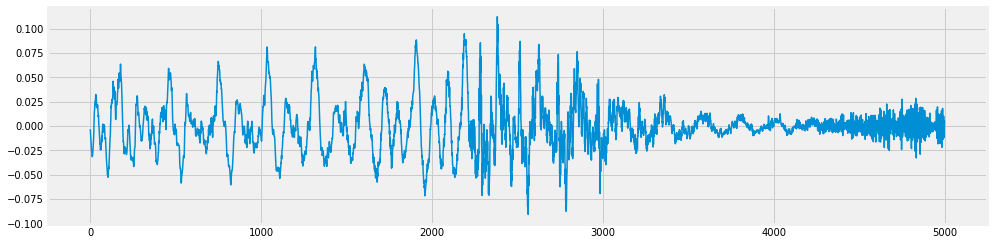

In [7]:
amplitudes, sample_rate = librosa.load("sample_m.wav")
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")
plt.figure(figsize=[15, 4])
plt.title('')
plt.plot(amplitudes[20000:25000],linewidth=1.5)

Разделяем вход на пересекающиеся фреймы

In [0]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

Применяем к каждому фрейму преобразование Фурье

In [0]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

Переводим полученную спектрограмму в мел-пространство

In [0]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [0]:
amplitudes1, _  = librosa.load('sample_m.wav') # Считываем амплитуды
amplitudes2, _  = librosa.load('sample_f.wav')

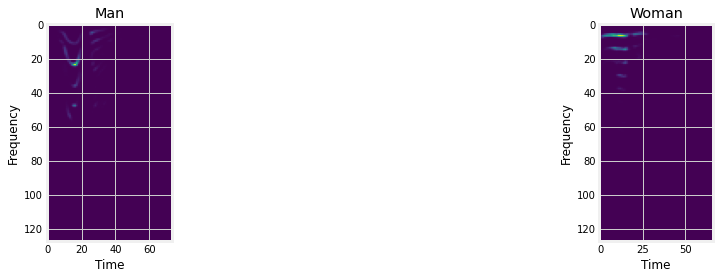

In [12]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("Man"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes1))

plt.subplot(1, 2, 2)
plt.title("Woman"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes2));

Проверяем правильность, полученных с помощью нашей функции, спектрограмм. Сравниваем с методом получения спектрограмм из librosa.

In [0]:
ref1 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

In [14]:
((ref1-get_melspectrogram(amplitudes2)) **2).mean() # Посмотрим на MSE

4.717526497791717e-13

Скачиваем dataset

In [15]:
!wget https://ndownloader.figshare.com/files/10256148

--2020-06-05 06:58:18--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.240.76.206, 34.251.49.190, 18.203.18.207, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.240.76.206|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2020-06-05 06:58:19--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.109.67
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.109.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148’

10256148            100%[===================>] 419.81M  11.8MB/s    in 38s     

2020-06-05 06:58:58 (11.1 MB/s) - ‘10256148’ saved [440207227/440207227]



In [0]:
!unzip -q 10256148

In [17]:
!pip install timit-utils # Библиотека для работы с датасетами формата TIMIT

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=7e59c1b6a03fc66c1a743f578a9c3fb8f62030bf62c054c2c157ef62b66cf82a
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'

# Создаем класс, который загружает и парсит информацию о спикерах
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

In [0]:
# Для проверки функций
corpus = tu.Corpus(DATA_PATH)
person_1 = corpus.train.person_by_index(100)

In [0]:
# Обработаем данные
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = 0 if gender == 'F' else 1
    return np.float32(spectrogram), np.int64(target)
    
tmp_1 = preprocess_sample(person_1.sentence_by_index(1).raw_audio, Speakers_info.return_sex(person_1.name))[0]
tmp_2 = librosa.feature.melspectrogram(person_1.sentence_by_index(1).raw_audio, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

Создадим тестсет и трейнсет из данных для TIMIT

In [0]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [22]:
trainset = create_dataset('train')
testset = create_dataset('test')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
# Разделим трэйнсет на подвыборки
X, y = map(np.stack, zip(*trainset))
# X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [24]:
X_train.shape

(3000, 128, 150)

In [0]:
X_train = torch.FloatTensor(X_train)
y_train = torch.IntTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.IntTensor(y_val)

In [0]:
len(y_train)

3000

In [25]:
# Создаем модель классификатора
from torch import nn


torch.manual_seed(42)
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(X_train.shape[2], 128),
    nn.Conv1d(128, 32, 4),
    nn.ReLU(),
    nn.Conv1d(32, 64, 4),
    nn.ReLU(),
    nn.Conv1d(64, 128, 4),
    nn.ReLU(),
    nn.AdaptiveAvgPool1d(128),
    nn.Linear(128, 2)
) #nn.Softmax()

model

Sequential(
  (0): Linear(in_features=150, out_features=128, bias=True)
  (1): Conv1d(128, 32, kernel_size=(4,), stride=(1,))
  (2): ReLU()
  (3): Conv1d(32, 64, kernel_size=(4,), stride=(1,))
  (4): ReLU()
  (5): Conv1d(64, 128, kernel_size=(4,), stride=(1,))
  (6): ReLU()
  (7): AdaptiveAvgPool1d(output_size=128)
  (8): Linear(in_features=128, out_features=2, bias=True)
)

In [0]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
num_epoch = 30

In [0]:
from torch.utils.data import DataLoader, TensorDataset

In [0]:
dataset = TensorDataset(X_train, y_train)

In [0]:
def train(num_epoch):
    train_losses = []
    test_losses = []
    for _ in range(num_epoch):
      for X_train, y_train in DataLoader(dataset):
        model.train(True)
        y_pred = model(X_train)
        print(y_pred.shape)
        print(y_train.shape)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        model.train(False)
        test_losses.append(loss_fn(model(X_val), y_val).item())
    return train_losses, test_losses


In [34]:
train_losses, test_losses = train(30)

torch.Size([1, 128, 2])
torch.Size([1])


ValueError: ignored